In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import multiprocessing
import time
import numpy as np
import scipy as sp
import emcee
import sys
import pickle
import TPmod
from scipy import interpolate 
from IPython.display import display
%matplotlib inline

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
BTprof = np.loadtxt("BTtemp800_45_13.dat")

In [3]:
logcoarsePress = np.arange(-4.0, 2.5, 0.53)
#logcoarsePress = np.arange(-4.0, 3.0, 0.5)
coarsePress = pow(10,logcoarsePress)
logfinePress = np.arange(-4.0, 2.4, 0.1)
finePress = pow(10,logfinePress)
# forward model wants pressure in mbar
press = finePress
nprof = coarsePress.size
proftype = 2

In [4]:
tfit = sp.interpolate.splrep(np.log10(coarsePress),BTprof+700.,s=0)
BTfine = np.asfortranarray(sp.interpolate.splev(np.log10(press),tfit,der=0),dtype='d')
err_BT = np.ones_like(BTfine)
err_BT[:] = 5.00

In [5]:
def lnlike(theta, press, temp, terr):
    madTP = TPmod.set_prof(proftype,coarsePress,press,theta)
    s2=terr**2
    lnlik = -0.5*np.sum((((BTfine - madTP)**2) / s2) + np.log(2.*np.pi*s2))
    return lnlik
                        

In [6]:
def lnprior(theta,press):
    a1 = theta[0]
    a2 = theta[1]
    P1 = theta[2]
#    P2 = theta[3]
    P3 = theta[3]
    T3 = theta[4]
    if 0. < a1 < 1. and 0. < a2 < 1.0 and T3 > 0.0 and P3 > P1 and P1 > np.log10(press[0]) and P3 < np.log10(press[press.size-1]) and T3 < 10000.:
        return 0.0
    return -np.inf

In [7]:
def lnprob(theta, press, temp, terr):
    lp = lnprior(theta,press)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, press, temp, terr)

In [8]:
ndim, nwalkers = 5, 500
p0 = np.empty([nwalkers,ndim])

In [9]:
p0[:,0] = np.random.rand(nwalkers).reshape(nwalkers)
p0[:,1] = np.random.rand(nwalkers).reshape(nwalkers)
p0[:,2] = -4. + (np.random.rand(nwalkers).reshape(nwalkers) * 5)
#p0[:,3] = p0[:,2] + np.random.rand(nwalkers).reshape(nwalkers) * 50.
p0[:,3] = p0[:,2] + np.random.rand(nwalkers).reshape(nwalkers) *3.
p0[:,4] = np.random.rand(nwalkers).reshape(nwalkers) * 2000.0

In [10]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(press, BTfine, err_BT),threads=4)

In [11]:
start_time = time.time()
sampler.run_mcmc(p0, 30000)
print("--- %s seconds ---" % (time.time() - start_time))

--- 4458.03805995 seconds ---


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


In [12]:
samples = sampler.chain[:, 8000:, :].reshape((-1, ndim))
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))
print sampler.chain.shape
print("autocorrelation time: {0:.3f}"
                .format(np.mean(sampler.acor)))

Mean acceptance fraction: 0.418
(500, 30000, 5)
autocorrelation time: 89.265


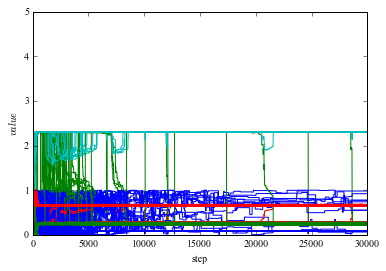

In [20]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0, 30000, 0.,5.])
index = np.arange(30000)
for i in range(0,250):
    plt.plot(index[:],sampler.chain[i,:,0],'r-')
    plt.plot(index[:],sampler.chain[i,:,1],'b-')
    plt.plot(index[:],sampler.chain[i,:,2],'g-')
    plt.plot(index[:],sampler.chain[i,:,3],'c-')
    plt.plot(index[:],sampler.chain[i,:,4],'y-')
#    plt.plot(index[:],sampler.chain[i,:,5],'y-')
    
plt.ylabel(r'$value$')
plt.xlabel('step')


In [14]:
 a1 , a2, P1,P3, T3 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [15]:
print a1
print a2
print P1
#print P2
print P3
print T3

(0.65882015399658933, 0.0066871246379970328, 0.0075653801012469657)
(0.083818922576778532, 0.00047371436414433976, 0.00049602910322350813)
(0.24934340848924003, 0.012641630588794306, 0.010649342279358931)
(2.2999271448281835, 5.6137244649701046e-05, 0.00013740434771092325)
(4574.6058515059467, 5.7583095726158717, 6.558897752820485)


In [16]:
test= [a1[0],a2[0],P1[0], P3[0],T3[0]]
madprof =  TPmod.set_prof(proftype,coarsePress,press,test)
print test

[0.65882015399658933, 0.083818922576778532, 0.24934340848924003, 2.2999271448281835, 4574.6058515059467]


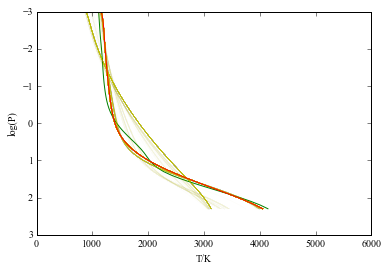

In [17]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([5., 6000.,3.0,-3.0])
#plt.plot(outspec[0,:],(outspec[1,:] / B),'r-')
#plt.plot(outspec[0,:],B,'b-')
#plt.fill_between(T[:,1],T[:,2], logP,facecolor='red',interpolate=True)
#plt.plot(T[:,1],logP,'r--')
#plt.plot(T[:,2],logP,'r--')
logP = np.log10(press)
plt.plot(BTfine,logP,'g-')
sampT = np.ones_like(test)
for sampT[:] in samples[(np.random.randint(len(samples[:,:]), size=5000)),:]:
    plotT = TPmod.set_prof(proftype,coarsePress,press,sampT)
    plt.plot(plotT,logP, color="y", alpha=0.02)

plt.plot(madprof,logP,'r-')

plt.ylabel(r'log(P)')
plt.xlabel('T/K')

#as

In [18]:
print madprof

[  544.79650947   639.56251427   732.60439315   820.42828629   900.15293517
   969.78914103  1028.36090399  1075.86380264  1113.09172823  1141.38581879
  1162.36509658  1177.68864636  1188.88019407  1197.22499641  1203.73198452
  1209.14418303  1213.97764833  1218.57163656  1223.13781036  1227.8017464
  1232.63440052  1237.67400295  1242.92629248  1248.42278479  1254.16358577
  1260.14912867  1266.38037117  1272.85934028  1279.59014615  1286.58077549
  1293.8461055   1301.41270877  1309.32610532  1317.66109716  1326.53561912
  1336.12809592  1346.69759409  1358.6051605   1372.33380828  1388.50389195
  1407.88038233  1431.36902972  1459.99965662  1494.89669465  1537.23076512
  1588.17895304  1648.86881491  1720.32651171  1803.42789991  1898.85265372
  2007.03913352  2128.13622539  2261.94862596  2407.87458949  2564.8399591
  2731.23854997  2904.89499786  3083.06981925  3262.52544534  3439.66501259
  3610.74297595  3772.13046443  3920.60278676  4053.60634304]


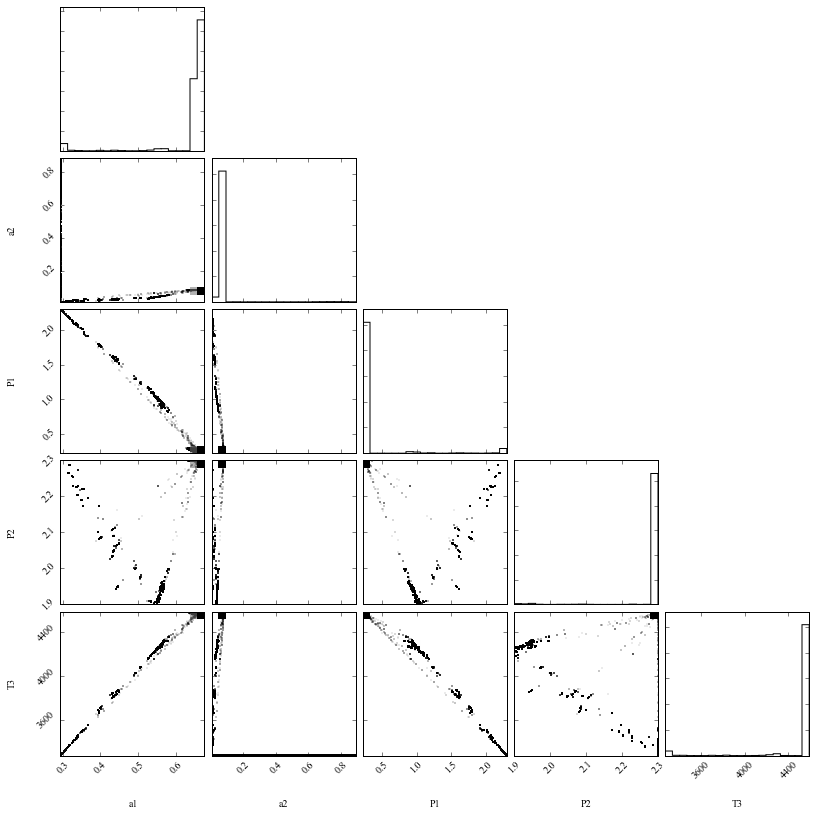

In [19]:
import corner
fig = corner.corner(samples, labels=["a1", "a2", "P1","P2","T3"],range=[0.99,0.99,0.99,0.99,0.99])